#Carga del dataset e .info()

In [0]:
import os
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import json
import missingno
import matplotlib.ticker as mtick
plt.rcParams["figure.figsize"] = (20,10)



#verifica que exista en el path y sino crea el json de autenticación y descarga el dataset
if not os.path.exists("dataset") :

    auth = {
        'username': 'germansequeira',
        'key': '8f018b0554bd94698d53b7bb4c10c7eb'
    }

    with open('kaggle.json', 'w') as json_file:
        json.dump(auth, json_file)

    ! pip install -q kaggle
    ! mkdir ~/.kaggle
    ! cp kaggle.json ~/.kaggle/
    ! chmod 600 ~/.kaggle/kaggle.json
    ! kaggle competitions download -c nlp-getting-started
    os.mkdir('dataset')
    os.rename("train.csv", "dataset/train.csv")
    os.rename("test.csv", "dataset/test.csv")
    os.rename("sample_submission.csv", "dataset/sample_submission.csv")

#cargamos el dataset correcto (train.csv)
dataset = pd.read_csv('dataset/train.csv')
dataset.target = dataset.target.astype('bool')

# seteamos el id como index
dataset = dataset.set_index('id')

#Asignamos la longitud del tweet a una nueva columna
dataset['longitud'] = dataset.text.str.len()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 61.1MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 64.1MB/s]
  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 23.2MB/s]


#Info agregada por Germán

##Análisis de tweets repetidos

In [0]:
#Cantidad de tweets repetidos
grupo = dataset[dataset.duplicated()]

grupo['cantidad'] = 1

grupo = grupo.groupby(['keyword', 'location', 'text', 'target', 'longitud']).agg({'cantidad':['sum']})
grupo.columns = ['repeticiones']

grupo = grupo.reset_index()

grupo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,keyword,location,text,target,longitud,repeticiones
0,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,False,114,1
1,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,False,138,1
2,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,False,138,1
3,derailment,India,Madhya Pradesh Train Derailment: Village Youth...,True,63,1
4,detonate,"Morioh, Japan",@TinyJecht Are you another Stand-user? If you ...,False,99,2
5,detonate,"Morioh, Japan",@spinningbot Are you another Stand-user? If yo...,False,101,2
6,displaced,Pedophile hunting ground,#Myanmar Displaced #Rohingya at #Sittwe point...,True,136,1
7,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #G...,True,134,2
8,mass%20murder,Anonymous,http://t.co/c1H7JECFrV @RoyalCarribean do your...,True,134,1
9,rescue,"Toronto, Ontario",UD: Rescue (Structural Collapse) - Scott Road ...,True,75,1


##Análisis de tweets por su veracidad y ubicación

Text(0.5, 1.0, 'Cantidad de tweets verídicos según ubicación')

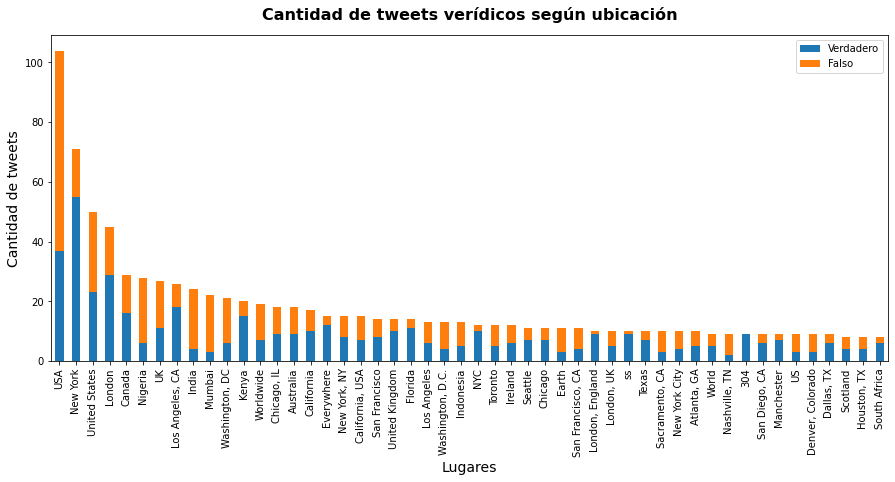

In [0]:
#tweets y su veracidad por ubicación

grupo = dataset.groupby(['location', 'target']).agg({'target': 'count'})
grupo.columns = ['Cantidad']
grupo = grupo.reset_index()
grupo = grupo.pivot_table(index = 'location', columns = 'target', values = 'Cantidad', fill_value = 0)
grupo.columns = ['Verdadero', 'Falso']
grupo['Total'] = grupo.Verdadero + grupo.Falso
grupo = grupo.sort_values(by = 'Total', ascending=False)
grupo = grupo.drop(columns = ['Total']).head(50)


fig, ax = plt.subplots(figsize=(15,6))
grupo.plot.bar(ax = ax, stacked = True)
ax.set_ylabel('Cantidad de tweets',fontsize=14)
plt.xlabel("Lugares",fontsize=14)
ax.set_title('Cantidad de tweets verídicos según ubicación',fontsize=16,fontweight='bold', pad = 15)


##Análisis de tweets por su veracidad y longitud

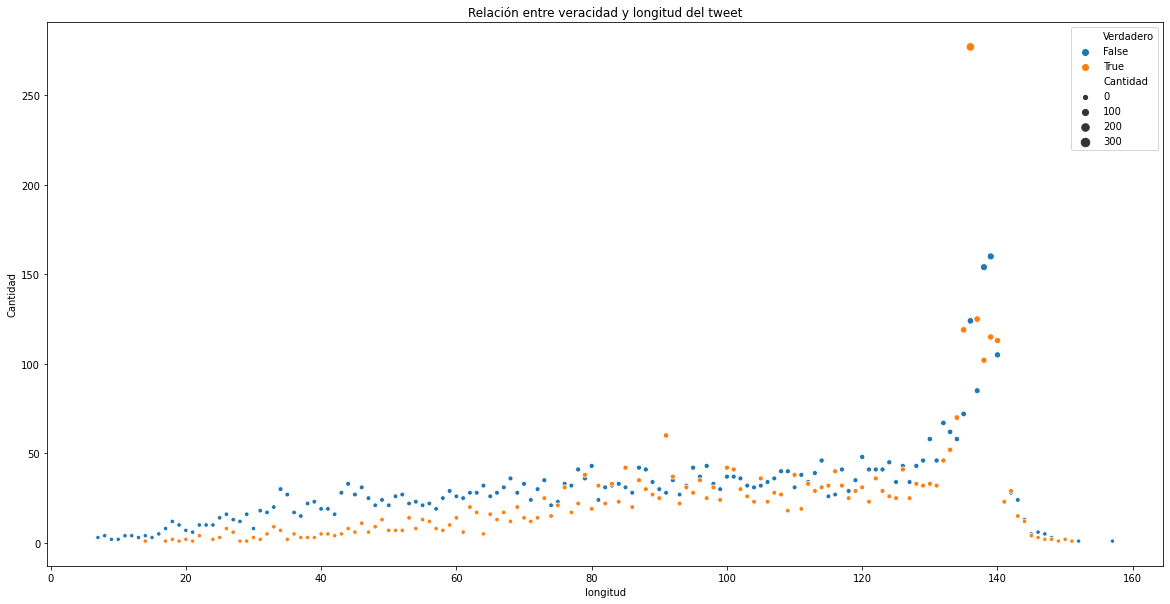

In [0]:
#Tweets por longitud y veracidad
grupo = dataset.groupby(['longitud', 'target']).agg({'target':['count']})
grupo.columns = ['Cantidad']

grupo = grupo.reset_index()
grupo = grupo.rename(columns={'target':'Verdadero'})

ax = sns.scatterplot(x = 'longitud', y = 'Cantidad', data = grupo, hue = 'Verdadero', size = 'Cantidad')
ax.set_title('Relación entre veracidad y longitud del tweet')
fig = ax.get_figure()
fig.savefig('figure.png')


# Info agregada por Cele

## Análisis de la estructura y tipos de datos. Valores nulos

In [0]:
dataset.head(5)

,keyword,location,text,target,longitud
id,,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,True,69
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,True,38
5,NaN,NaN,All residents asked to 'shelter in place' are ...,True,133
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",True,65
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,True,88


In [0]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 1 to 10873
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   bool  
 4   longitud  7613 non-null   int64 
dtypes: bool(1), int64(1), object(3)
memory usage: 304.8+ KB


## Análisis veracidad de los tweets segun su longitud(determina si el tweet habla de un desastre natural o no)

In [0]:
#estadisticas de la longitud de los tweets
dataset.longitud.describe()

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: longitud, dtype: float64

In [0]:
# Creo dos df con los tweets verdaderos y falsos respectivamente
# de tratarse de un DF más grande debería utilizar otra estrategia
# como por ejemplo hacer un groupby por la columna target
tweet_len_true = dataset.loc[(dataset['target']),'longitud']
tweet_len_false = dataset.loc[(dataset['target']==False),'longitud']

tweet_len_true

id
1         69
4         38
5        133
6         65
7         88
        ... 
10869     83
10870    125
10871     65
10872    137
10873     94
Name: longitud, Length: 3271, dtype: int64

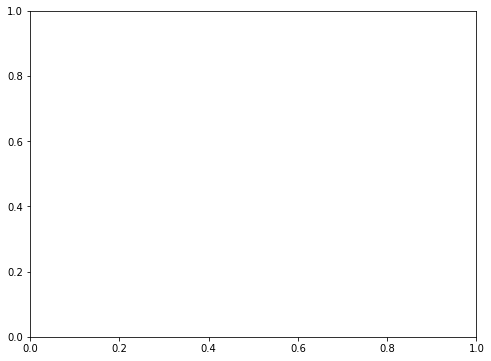

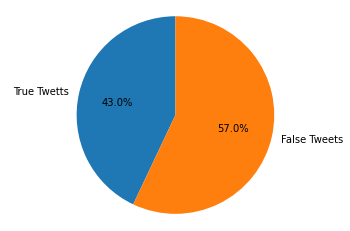

In [0]:

tweet_totals = dataset['longitud'].count()
tweet_true_count = tweet_len_true.count()
tweet_false_count = tweet_len_false.count()

fig, ax = plt.subplots(figsize=(8,6))

labels = 'True Twetts', 'False Tweets'
sizes = [tweet_true_count, tweet_false_count]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

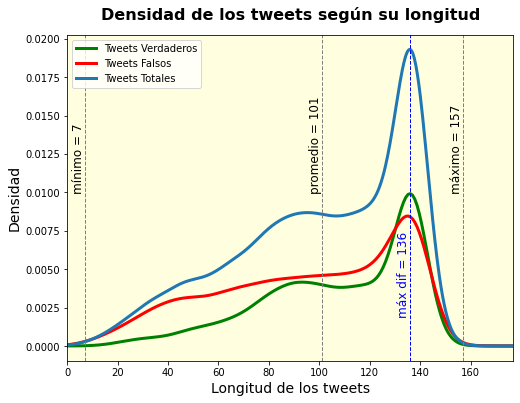

In [0]:
from scipy.stats import gaussian_kde

kernel_true = gaussian_kde(tweet_len_true)
kernel_false = gaussian_kde(tweet_len_false)
x_lim = dataset['longitud'].max()+20
X = np.linspace(0,x_lim,200)
Y_true = kernel_true.evaluate(X)*tweet_true_count/tweet_totals
Y_false = kernel_false.evaluate(X)*tweet_false_count/tweet_totals

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(X, Y_true , label='Tweets Verdaderos', color = 'green', linewidth=3)
ax.plot(X, Y_false , label='Tweets Falsos', color = 'red', linewidth=3)
dataset['longitud'].plot(kind='kde', ax=ax, label='Tweets Totales', linewidth=3, xlim=(0, x_lim))

plt.xlabel('Longitud de los tweets',fontsize=14)
plt.ylabel('Densidad',fontsize=14)
plt.title('Densidad de los tweets según su longitud',fontsize=16,fontweight='bold', pad = 15)
ax.set_facecolor('lightyellow')

# calculo las estadísticas pedidas sobre el total de los tweets
min_len = dataset['longitud'].min()
mean_len = dataset['longitud'].mean()
max_len = dataset['longitud'].max()

# calculo el punto donde hay mayor diferencia entre los 
# tweets verdaderos y los falsos
max_diff = (tweet_len_true.value_counts()-tweet_len_false.value_counts()).dropna().abs().idxmax()

ax.axvline(mean_len, color='grey', linestyle='--', linewidth=1)
ax.axvline(min_len, color='grey', linestyle='--', linewidth=1)
ax.axvline(max_len, color='grey', linestyle='--', linewidth=1)
ax.axvline(max_diff, color='blue', linestyle='--', linewidth=1)

plt.text(min_len - 5 , ax.get_ylim()[1]/2, 'mínimo = %d' %min_len, rotation = 90, fontsize = 12)
plt.text(mean_len - 5 , ax.get_ylim()[1]/2, 'promedio = %d' %mean_len, rotation = 90, fontsize = 12)
plt.text(max_len - 5 , ax.get_ylim()[1]/2, 'máximo = %d' %max_len, rotation = 90, fontsize = 12)

plt.text(max_diff- 5 , ax.get_ylim()[1]/10, 'máx dif = %d' %max_diff, rotation = 90, fontsize = 12, color = 'blue')

plt.legend()

## Análisis de los hashtags

In [0]:
# extrae los hashtags de un texto y devuelve una lista 
def hashtags(text):
    result = []
    for token in text.split():
        if token[0]=='#':
            result.append(token.replace('#', '').lower())
    return result    

text = 'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'
hashtags(text)

['earthquake']

In [0]:
dataset['hashtags'] = dataset.text.apply(lambda x : hashtags(x))
dataset.head(5)

,keyword,location,text,target,longitud,hashtags
id,,,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,True,69,[earthquake]
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,True,38,[]
5,NaN,NaN,All residents asked to 'shelter in place' are ...,True,133,[]
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",True,65,[wildfires]
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,True,88,"[alaska, wildfires]"


In [0]:
df_hashtags = dataset.explode('hashtags')
df_hashtags.head(20)

,keyword,location,text,target,longitud,hashtags
id,,,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,True,69,earthquake
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,True,38,NaN
5,NaN,NaN,All residents asked to 'shelter in place' are ...,True,133,NaN
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",True,65,wildfires
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,True,88,alaska
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,True,88,wildfires
8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,True,110,rockyfire
8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,True,110,cafire
8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,True,110,wildfires


In [0]:
# hay que ver si vale la pena porque hay muy pocos hashtags en comparacion al tamaño del dataset
df_hashtags.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9219 entries, 1 to 10873
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   9138 non-null   object
 1   location  6080 non-null   object
 2   text      9219 non-null   object
 3   target    9219 non-null   bool  
 4   longitud  9219 non-null   int64 
 5   hashtags  3340 non-null   object
dtypes: bool(1), int64(1), object(4)
memory usage: 441.1+ KB


In [0]:
top_hashtags_series = df_hashtags.hashtags.value_counts().nlargest(50)
top_hashtags = pd.DataFrame(top_hashtags_series).reset_index()
top_hashtags.columns = ['hashtags','Cantidad']
top_hashtags.head()


,hashtags,Cantidad
0,news,72
1,hot,30
2,prebreak,30
3,best,30
4,???,23


In [0]:
top_hashtags.Cantidad.sum()

633

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


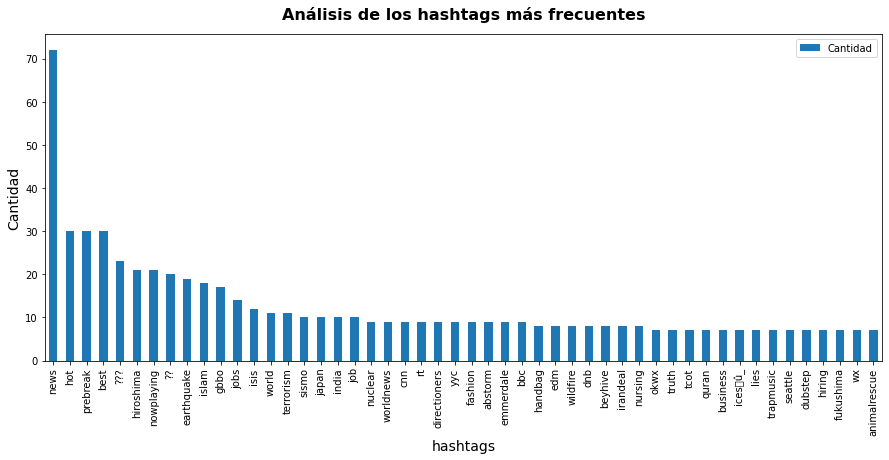

In [0]:

fig, ax = plt.subplots(figsize=(15,6))


plt.xlabel("Hashtags",fontsize=14)
plt.ylabel('Cantidad',fontsize=14)
plt.title('Análisis de los hashtags más frecuentes',fontsize=16,fontweight='bold', pad = 15)

top_hashtags.plot.bar(x='hashtags',y='Cantidad', ax = ax)

plt.show()

## Análisis por ubicacion

In [0]:
dataset.location.value_counts()

USA                          104
New York                      71
United States                 50
London                        45
Canada                        29
                            ... 
Albuquerque                    1
MI                             1
Terlingua, Texas               1
My heart is a ghost town!      1
Raleigh Durham, NC             1
Name: location, Length: 3341, dtype: int64

In [0]:
dataset.location.isnull().value_counts()

False    5080
True     2533
Name: location, dtype: int64

In [0]:
top_locations = dataset.location.value_counts().reset_index()
top_locations.columns = ['Ubicacion', 'Cantidad']
top_locations.head()

,Ubicacion,Cantidad
0,USA,104
1,New York,71
2,United States,50
3,London,45
4,Canada,29


In [0]:
top_locations.describe()
# hay muchas ciudades con un solo elemento, como que la "cola" tiene mucho peso

,Cantidad
count,3341.000000
mean,1.520503
std,3.022364
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,104.000000


In [0]:
# cantidad de ubicaciones con un solo elemento (son muchas!! 2818 / 3341)
top_locations.loc[top_locations['Cantidad']< 2].count()

Ubicacion    2818
Cantidad     2818
dtype: int64

Text(0.5, 1.0, 'Análisis de las ubicaciones más frecuentes')

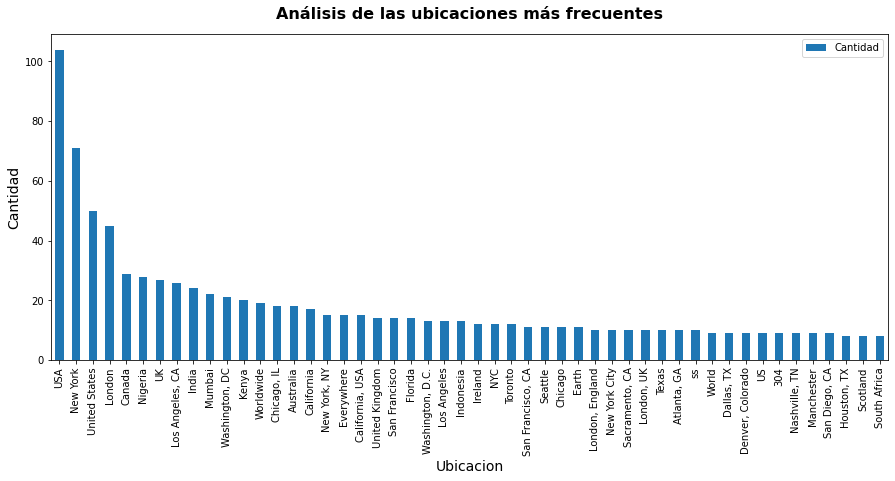

In [0]:
fig, ax = plt.subplots(figsize=(15,6))

top_locations.nlargest(50, 'Cantidad').plot(kind='bar', x = 'Ubicacion', ax = ax)

plt.xlabel("Ubicacion",fontsize=14)
plt.ylabel('Cantidad',fontsize=14)
plt.title('Análisis de las ubicaciones más frecuentes',fontsize=16,fontweight='bold', pad = 15)




## Análisis por keywords

In [0]:
dataset.keyword.value_counts()

fatalities               45
deluge                   42
armageddon               42
body%20bags              41
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [0]:
dataset.keyword.isnull().value_counts()

False    7552
True       61
Name: keyword, dtype: int64

In [0]:
top_keywords = dataset.keyword.value_counts().reset_index()
top_keywords.columns = ['Keywords', 'Cantidad']

top_keywords.head(5)

,Keywords,Cantidad
0,fatalities,45
1,deluge,42
2,armageddon,42
3,body%20bags,41
4,sinking,41


In [0]:
top_keywords.describe()
# estan distribuidas bastante uniformemente

,Cantidad
count,221.000000
mean,34.171946
std,4.786091
min,9.000000
25%,33.000000
50%,35.000000
75%,37.000000
max,45.000000


Text(0.5, 1.0, 'Análisis de las keywords más frecuentes')

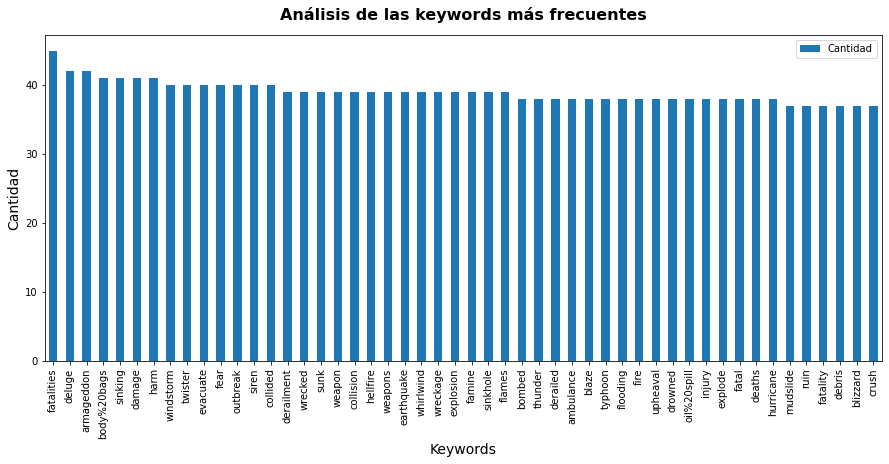

In [0]:
fig, ax = plt.subplots(figsize=(15,6))

top_keywords.nlargest(50,'Cantidad').plot(kind='bar', x = 'Keywords', ax = ax)

plt.xlabel("Keywords",fontsize=14)
plt.ylabel('Cantidad',fontsize=14)
plt.title('Análisis de las keywords más frecuentes',fontsize=16,fontweight='bold', pad = 15)


#agrego texto para probar cambios 

# Info agregada por ...

In [0]:
# Pongan toda la info en celdas como estas